In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

import matplotlib.pyplot as plt

In [27]:
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

## Comparing set vs pinball on Improved Implementation.

In [5]:
class set_safe_AwACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
         val = (optimal_set - given_set) 
         if val < 0:
              return (self.coverage_target) * (-1* val)
         else:
              return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-2, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        all_head_radii = []
        all_interval_weights = []



        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.ones(len(interval_candidates))
        culmative_loss = np.zeros(len(interval_candidates))
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
                
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            try:
                chosen_set = random.choices(head_sets, weights=interval_weights, k=1)[0] # Using random module as numpy can not deal with tuples.
            except ValueError:
                print(all_interval_weights[-5:])
                raise ValueError('Interval probabilities are not normalised correctly.')
            
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2
            head_set_radius = np.array(head_set_radius)
            
            # Calculating the loss.
            culmative_loss += Set_loss(optimal_set_radius, head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
            final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean
            
            interval_weights = final_weights/sum(final_weights)


            # Incrementing the i-count
            i_count+=1

            # Appending the results to the lists.
            err_t_list.append(err_true)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) 
            optimal_radius_list.append(optimal_set_radius)
            all_head_radii.append(head_set_radius)
            all_interval_weights.append(interval_weights)

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'safe AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }


In [6]:
class pinball_safe_AwACI(AdaptiveCP):
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
            xpred, y = timeseries_data
            alpha_t_list = [self.coverage_target]

            All_scores = self.score_function(xpred, y)

            err_t_list = []
            conformal_sets_list = []

            pinball_loss = self.vectorize_l()
            
            for i in range(start_point, len(All_scores)):
                Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
                conformal_sets_list.append(Coverage_t)

                # Finding B_t
                low, high = 0, 999 
                possibilities = np.linspace(0, 1, 1000) # as 1 - 

                B_t = 1
                while low <= high:
                    mid = (high + low) // 2
                    possi = possibilities[mid]
                    Cpossi = self.C_t(possi, All_scores, xpred[i], i, custom_interval)

                    if Cpossi[0] < y[i] < Cpossi[1]:
                        B_t = possi
                        low = mid + 1
                    else:
                        high = mid - 1

                yield Coverage_t, pinball_loss(B_t, alpha_t_list[-1])

                error_t = AdaptiveCP.err_t(y[i], Coverage_t)
                err_t_list.append(error_t)

                alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
                alpha_t_list.append(alpha_t)

            return False
        
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
            
            _, y = timeseries_data

            chosen_interval_index = []
            err_t_list = []
            conformal_sets_list = []
            optimal_radius_list = []
            chosen_radius_list = []
            all_interval_weights = []

            # Scale parameters, havent looked into scaling them best.
            sigma = nu_sigma[1]
            nu = nu_sigma[0] 

            if interval_candidates is None:
                interval_candidates = np.array(range(50, 550, 100))

            # To sync all of the heads we need to start at the max of all the candidates.
            start_point = max(interval_candidates) + 1
            i_count = start_point

            # Create the head and intitialse the weights.
            ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
            interval_weights = np.ones(len(interval_candidates))
            culmative_loss = np.zeros(len(interval_candidates))
            
            # Continues calculating intervals until one of the heads stops.
            none_terminated = True

            while none_terminated: 
                head_sets = [] # Will contain the result from each head.
                pinball_loss_list = [] # Will contain the B_t values for each head.
                
                # Create the mass distribution for each head

            
                try:
                    # Create a list of the coverages for the different heads.
                    for head in ACI_heads:
                            coverage, loss = next(head)
                            
                            head_sets.append(coverage)
                            pinball_loss_list.append(loss)

                except StopIteration: # One head is terminated.
                    none_terminated = False
                    break # You could but the return statement here

                # Choosing which head to use.
                chosen_set = random.choices(head_sets, weights=interval_weights, k=1)[0] # Using random module as numpy can not deal with tuples.

                # TIME FRONTIER -------------

                # Seeing whether result lies within the set.
                err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

                # Calculating the loss.
                culmative_loss += np.array(pinball_loss_list)

                # Updating the weights.
                new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
                final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean

                interval_weights = final_weights/sum(final_weights)


                # Incrementing the i-count
                i_count+=1

                err_t_list.append(err_true)
                conformal_sets_list.append(chosen_set)
                chosen_interval_index.append(head_sets.index(chosen_set))
                all_interval_weights.append(interval_weights)
                
            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

            return {
                    'model': title if title is not None else 'pinball AwACI',
                    'coverage_target': self.coverage_target,
                    'interval_candidates': interval_candidates,
                    'realised_interval_coverage': realised_interval_coverage,
                    'average_prediction_interval': average_prediction_interval,
                    'optimal_set_radius': optimal_radius_list, 
                    'chosen_set_radius': chosen_radius_list,
                    'conformal_sets': conformal_sets_list,
                    'error_t_list': err_t_list,
                    'chosen_interval_index': chosen_interval_index,
                    'start_point': start_point,
                    'interval_size': 50,
                    'all_weights': all_interval_weights
                }

In [9]:
pACP = pinball_safe_AwACI(coverage_target=0.1)
sACP = set_safe_AwACI(coverage_target=0.1)
oACP = AdaptiveCP(coverage_target=0.1)

# Getting the data

In [8]:
mulit_shift = ACP_data.random_multi_shift(100, (2500,2501), number_shift_range=(5,8))

# Comparing

In [11]:
# For the random data
set_dict = {'coverge':[], 'width':[]}
pinball_dict = {'coverge':[], 'width':[]}
org_dict = {'coverge':[], 'width':[]}
aci_dict = {'coverge':[], 'width':[]}

for i, data in enumerate(mulit_shift):
    set = sACP.AwACI(data, nu_sigma=(10**-3, 0.05))
    pin = pACP.AwACI(data, nu_sigma=(10**-2, 0.05))
    org = oACP.AwACI(data, nu_sigma=(10**-3, 0.05))
    aci = oACP.ACI(data, custom_interval=250)

    set_dict['coverge'].append(set['realised_interval_coverage'])
    set_dict['width'].append(set['average_prediction_interval'])

    pinball_dict['coverge'].append(pin['realised_interval_coverage'])
    pinball_dict['width'].append(pin['average_prediction_interval'])

    org_dict['coverge'].append(org['realised_interval_coverage'])
    org_dict['width'].append(org['average_prediction_interval'])

    aci_dict['coverge'].append(aci['realised_interval_coverage'])
    aci_dict['width'].append(aci['average_prediction_interval'])

    if i % 10 == 0:
        print(i)
    

0
10
20
30
40
50
60
70
80
90


In [12]:
set_coverage = np.array(set_dict['coverge'])
set_width = np.array(set_dict['width'])

pinball_coverage = np.array(pinball_dict['coverge'])
pinball_width = np.array(pinball_dict['width'])

org_coverage = np.array(org_dict['coverge'])
org_width = np.array(org_dict['width'])

aci_coverage = np.array(aci_dict['coverge'])
aci_width = np.array(aci_dict['width'])

# Printing the results
print('Set coverage:', np.mean(set_coverage), np.mean(set_width))
print('Pinball coverage:', np.mean(pinball_coverage), np.mean(pinball_width))
print('Org coverage:', np.mean(org_coverage), np.mean(org_width))
print('ACI coverage:', np.mean(aci_coverage), np.mean(aci_width))

Set coverage: 0.897424848274137 170.75200693037013
Pinball coverage: 0.8978170847923963 197.4684421863554
Org coverage: 0.8981442765382691 176.47711230933072
ACI coverage: 0.8981962591260491 171.14592094347915


In [ ]:
new_transform = lambda x: np.append(x[:2], 0.5*x[:-2] + 0.5*x[1:-1] + x[2:])


In [15]:
print(pd.Series(set_width).describe())
print(pd.Series(pinball_width).describe())
print(pd.Series(org_width).describe())
print(pd.Series(aci_width).describe())


count     100.000000
mean      170.752007
std       159.309718
min        33.687784
25%        98.697560
50%       135.064007
75%       176.293213
max      1288.795760
dtype: float64
count     100.000000
mean      197.468442
std       207.217906
min        33.543011
25%       102.701353
50%       147.254386
75%       194.029290
max      1386.509741
dtype: float64
count     100.000000
mean      176.477112
std       146.179381
min        33.478720
25%        97.045079
50%       141.309277
75%       200.597582
max      1018.809858
dtype: float64
count     100.000000
mean      171.145921
std       156.979958
min        29.674029
25%        95.216827
50%       131.764418
75%       179.786920
max      1048.597647
dtype: float64


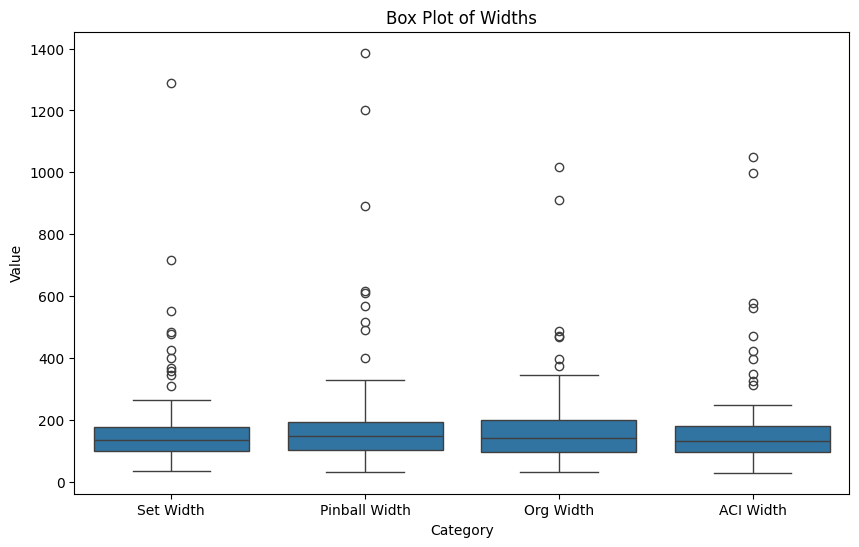

In [17]:
import seaborn as sns
# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Set Width': set_width,
    'Pinball Width': pinball_width,
    'Org Width': org_width,
    'ACI Width': aci_width
})

# Melt the DataFrame for Seaborn
melted_data = data.melt(var_name='Category', value_name='Value')

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Value', data=melted_data)
plt.title('Box Plot of Widths')
plt.show()

In [18]:
# For the random data
set_dict = {'coverge':[], 'width':[]}
pinball_dict = {'coverge':[], 'width':[]}
org_dict = {'coverge':[], 'width':[]}
aci_dict = {'coverge':[], 'width':[]}

for i, data in enumerate(mulit_shift[:10]):
    set = sACP.AwACI(data, nu_sigma=(10**-3, 0.2))
    pin = pACP.AwACI(data, nu_sigma=(10**-2, 0.2))
    org = oACP.AwACI(data, nu_sigma=(10**-3, 0.2))
    aci = oACP.ACI(data, custom_interval=250)

    set_dict['coverge'].append(set['realised_interval_coverage'])
    set_dict['width'].append(set['average_prediction_interval'])

    pinball_dict['coverge'].append(pin['realised_interval_coverage'])
    pinball_dict['width'].append(pin['average_prediction_interval'])

    org_dict['coverge'].append(org['realised_interval_coverage'])
    org_dict['width'].append(org['average_prediction_interval'])

    aci_dict['coverge'].append(aci['realised_interval_coverage'])
    aci_dict['width'].append(aci['average_prediction_interval'])

    if i % 10 == 0:
        print(i)

0


In [ ]:
print(pd.Series(set_width).describe())
print(pd.Series(pinball_width).describe())
print(pd.Series(org_width).describe())
print(pd.Series(aci_width).describe())


count     100.000000
mean      170.752007
std       159.309718
min        33.687784
25%        98.697560
50%       135.064007
75%       176.293213
max      1288.795760
dtype: float64
count     100.000000
mean      197.468442
std       207.217906
min        33.543011
25%       102.701353
50%       147.254386
75%       194.029290
max      1386.509741
dtype: float64
count     100.000000
mean      176.477112
std       146.179381
min        33.478720
25%        97.045079
50%       141.309277
75%       200.597582
max      1018.809858
dtype: float64
count     100.000000
mean      171.145921
std       156.979958
min        29.674029
25%        95.216827
50%       131.764418
75%       179.786920
max      1048.597647
dtype: float64


In [20]:
print(pd.Series(pinball_width).iloc[:10].describe())

count      10.000000
mean      283.200713
std       351.186660
min       103.426135
25%       117.285451
50%       146.093952
75%       166.918874
max      1201.700028
dtype: float64


In [19]:
new_pin_dict = {'coverge':[], 'width':[]}

for i, data in enumerate(mulit_shift[:10]):
    pin = pACP.AwACI(data, nu_sigma=(np.sqrt(2*np.log(2*5)/2000), 0.2))

    new_pin_dict['coverge'].append(pin['realised_interval_coverage'])
    new_pin_dict['width'].append(pin['average_prediction_interval'])

    if i % 10 == 0:
        print(i)

0


In [22]:
np.sqrt(2*np.log(2*5)/2000)

np.float64(0.04798525912188081)

In [21]:
print(pd.Series(new_pin_dict['width']).iloc[:10].describe())

count      10.000000
mean      288.647405
std       394.563862
min        75.765033
25%       130.247166
50%       156.795161
75%       171.006076
max      1383.442444
dtype: float64
